# Code generation with flow

AlphaCodium presented an approach for code generation [that uses a`flow` paradigm to construct an answer to a coding question iteratively.](https://x.com/karpathy/status/1748043513156272416?s=20). 

[AlphaCodium](https://github.com/Codium-ai/AlphaCodium) iteravely tests and improves an answer on public and AI-generated tests for a particular question. 

We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph):

1. We start with a set of documentation specified by a user
2. We use a long context LLM to ingest it, and answer a question based upon it 
3. We perform two unit tests: Check imports and code execution

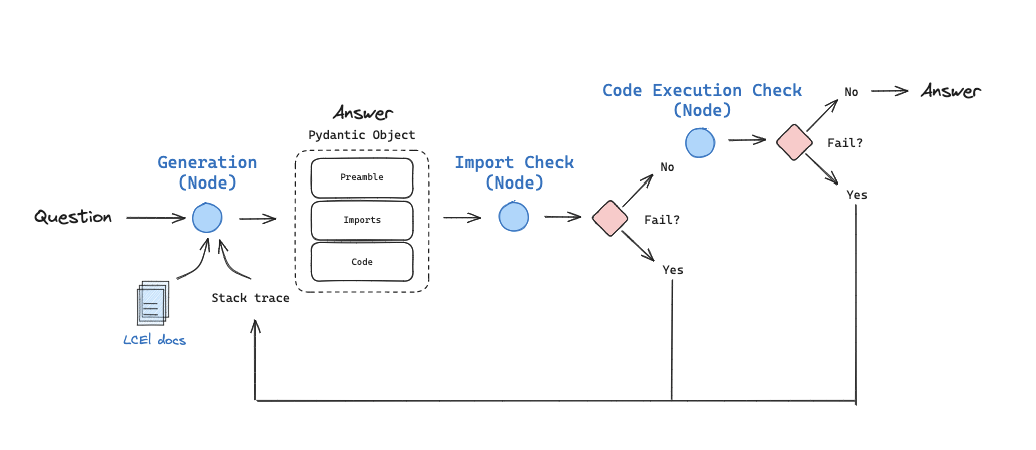

In [2]:
 ! pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph

## Documentation

Load [LangChain Expression Language](https://python.langchain.com/docs/expression_language/) (LCEL) docs.

In [1]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Add
docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLMs

We de-couple code solution and code formatting so that any LLM can be used for code solution. 

The structured output generation is handled in a seperate step.

### Code solution

In [13]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Grader prompt 
code_gen_prompt = ChatPromptTemplate.from_messages(
    [("system","""You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is a full set of LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user 
    question based on the above provided documentation. Ensure any code you provide can be executed \n 
    with all required imports and variables defined. Structure your answer with a description of the code solution. \n
    Then list the imports. And finally list the functioning code block. Here is the user question:"""),
    ("placeholder", "{messages}")]
)

# code_gen_llm = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")
code_gen_llm = ChatAnthropic(temperature=0, model='claude-3-opus-20240229')

code_gen_chain = code_gen_prompt | code_gen_llm | StrOutputParser()
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke({"context"  : concatenated_content,
                                  "messages" : [("user",question)], ..., ...})

### Formatted code

In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field

# Prompt
prompt = ChatPromptTemplate.from_messages(
        [("system","""You are an expert a code formatting, strating with a code solution \n
        Structure the solution in three parts with a prefix that defines the problem, then \n 
        list the imports, and finally list the functioning code block.""" ),
         ("user", "Here is the code solution: {code}"),]) 
    
# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# Formatter 
llm = ChatOpenAI(model="gpt-4-0125-preview", temperature=0)
llm_formatter = llm.with_structured_output(code)
structured_code_formatter = prompt | llm_formatter
output = structured_code_formatter.invoke([("code",solution)])

## State 

Our state is a dict that will contain keys (errors, question, code generation) relevant to code generation.

In [20]:
from typing import Dict, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question : Use question
        generation : LLM generation
        prefix : Parsed code prefix
        imports : Parsed code imports
        code : Parsed code block
        error : Errors from unit tests
    """

    question : str
    generation : str
    prefix : str
    imports: str
    code : str
    error : str

## Graph 

Our graph lays out the logical flow shown in the figure above.

Error handling loop is a sub-graph: 

start
- errors 

* generate node

* condititional edge: pass validation
  - if yes: END
  - if no: format error

* format error

In [22]:
from operator import itemgetter

from langchain.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough

def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    # State
    question = state["question"]
    iterations = state["iterations"]

    # No unit test errors 
    if "error" not in state:
        print("---GENERATE SOLUTION---")
        solution = code_gen_chain.invoke({"context"  : concatenated_content,
                                          "messages" : [("user",question)] })

    # We have a unit test error
    elif "error" in state:
        print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")
        
        # Get error and the prior generation that produced it
        error = state["error"]
        code_solution = state["generation"]

        # New message
        error_message = """  \n --- --- --- \n You previously tried to solve this problem. \n Here is your solution:  
                    \n --- --- --- \n {generation}  \n --- --- --- \n  Here is the resulting error from code 
                    execution:  \n --- --- --- \n {error}  \n --- --- --- \n Please re-try to answer this. 
                    Structure your answer with a description of the code solution. \n Then list the imports. 
                    And finally list the functioning code block. Structure your answer with a description of 
                    the code solution. \n Then list the imports. And finally list the functioning code block. 
                    \n Here is the user question: \n --- --- --- \n {question}"""


        ### Here we need to get all prior messages ### 
        ### Do we need to have these in state? ###
        ### More elegant way? ###

 
        messages = state["messages"]
        solution = code_gen_chain.invoke({"context"  : concatenated_content,
                                  "messages" : [("user",question)], ..., ...})
        
        messages = xxx
        messages += [
            (
                "user",
                error_message,
            )
        ]
        solution = code_gen_chain.invoke({"context"  : concatenated_content,
                                  "messages" : messages] })
        

    # Get structured output
    code_solution = structured_code_formatter.invoke([("code",solution)])
    # Increment
    iterations = iterations + 1
    return {
        "keys": {"generation": code_solution, "question": question, "iterations": iterations}
    }

def check_code_imports(state: GraphState):
    """
    Check imports

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    ## State
    print("---CHECKING CODE IMPORTS---")
    question = state["question"]
    code_solution = state["generation"]
    imports = code_solution[0].imports
    iterations = state_dict["iterations"]

    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error
    else:
        print("---CODE IMPORT CHECK: SUCCESS---")
        error = "None"

    return {
        "keys": {
            "generation": code_solution,
            "question": question,
            "error": error,
            "iterations": iterations,
        }
    }

def check_code_execution(state: GraphState):
    """
    Check code block execution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    ## State
    print("---CHECKING CODE EXECUTION---")
    question = state["question"]
    code_solution = state["generation"]
    prefix = code_solution[0].prefix
    imports = code_solution[0].imports
    code = code_solution[0].code
    code_block = imports + "\n" + code
    iterations = state_dict["iterations"]

    try:
        exec(code_block)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error
    else:
        print("---CODE BLOCK CHECK: SUCCESS---")
        error = "None"

    return {
        "keys": {
            "generation": code_solution,
            "question": question,
            "error": error,
            "prefix": prefix,
            "imports": imports,
            "iterations": iterations,
            "code": code,
        }
    }

### Edges

def decide_to_check_code_exec(state: GraphState):
    """
    Determines whether to test code execution, or re-try answer generation.

    Args:
       state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish (re-try code 3 times.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]
    iter = state_dict["iterations"]

    if error == "None" or iter == 3:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "end"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

SyntaxError: unterminated string literal (detected at line 51) (1848823301.py, line 51)

In [6]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code_imports", check_code_imports)  # check imports
workflow.add_node("check_code_execution", check_code_execution)  # check execution

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code_imports")
workflow.add_conditional_edges(
    "check_code_imports",
    decide_to_check_code_exec,
    {
        "check_code_execution": "check_code_execution",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "check_code_execution",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

# Compile
app = workflow.compile()

## Eval

Compare LangGraph to base case.

In [ ]:
def predict_base_case(example: dict):
    """ Context stuffing """
    solution = code_gen_chain.invoke({"context"  : concatenated_content,
                                      "messages" : [("user",example["question"])] })
    output = structured_code_formatter.invoke([("code",solution)])
    return {"imports": output.imports, "code": output.code}

def predict_langgraph(example: dict):
    """ LangGraph """
    graph = app.invoke([("question",example["question"])])
    return {"imports": graph["imports"], "code": graph["code"]}

[Here](https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d) is a public dataset of LCEL questions. 

In [ ]:
import langsmith

client = langsmith.Client()

public_dataset = (
    "https://smith.langchain.com/public/326674a6-62bd-462d-88ae-eea49d503f9d/d"
)
# Clone the dataset to your tenant to use it
client.clone_public_dataset(public_dataset)

Custom evals.

In [ ]:
from langsmith.schemas import Example, Run

def check_import(run: Run, example: Example) -> dict: 
    imports = run.outputs.get("imports")
    try:
        exec(imports)
        return {"key": "import_check" , "score": 1} 
    except:
        return {"key": "import_check" , "score": 0} 

def check_execution(run: Run, example: Example) -> dict: 
    imports = run.outputs.get("imports")
    code = run.outputs.get("code")
    try:
        exec(imports + "\n" + code)
        return {"key": "code_execution_check" , "score": 1} 
    except:
        return {"key": "code_execution_check" , "score": 0} 

In [ ]:
from langsmith.evaluation import evaluate

# Evaluator
code_evalulator = [check_import,check_execution]
dataset_name = "lcel-teacher-eval"

# Run base case
experiment_results = evaluate(
    predict_base_case,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix="test-without-langgraph",
    metadata={
      "variant": "Claude3",
    },
)

# Run with langgraph
experiment_results = evaluate(
    predict_langgraph,
    data=dataset_name,
    evaluators=code_evalulator,
    experiment_prefix="test-with-langgraph",
    metadata={
      "variant": "Claude3",
    },
)

## TODO: Clean This Later ## 

Compute standard error across 4 trials.

In [14]:
# You will have to update these to match the tests you ran.
# The test name can be found at langgraph_results["project_name"]
langgraph = [
    "80db-context-stuffing-with-langgraph",
    "060c-context-stuffing-with-langgraph",
    "93cd-context-stuffing-with-langgraph",
    "60ef-context-stuffing-with-langgraph",
]

In [15]:
no_langgraph = [
    "b493-context-stuffing-no-langgraph",
    "eb8a-context-stuffing-no-langgraph",
    "b88c-context-stuffing-no-langgraph",
    "0aaa-context-stuffing-no-langgraph",
]

In [39]:
import pandas as pd


def prepare_dataframe(project, trial_number, chain):
    df = client.get_test_results(project_name=project)
    df = df.dropna(subset=["feedback.check_execution", "feedback.check_import"])
    df = df[["input.question", "feedback.check_execution", "feedback.check_import"]]
    df["trial #"] = trial_number
    df["chain"] = chain
    return df


# Prepare each dataframe
dfs_chain1 = [
    prepare_dataframe(project, i + 1, "LangGraph")
    for i, project in enumerate(langgraph)
]
dfs_chain2 = [
    prepare_dataframe(project, i + 1, "No LangGraph")
    for i, project in enumerate(no_langgraph)
]

# Combine all dataframes
final_df = pd.concat(dfs_chain1 + dfs_chain2, ignore_index=True)

In [42]:
final_df.groupby("chain").size()

chain
LangGraph       78
No LangGraph    79
dtype: int64

In [40]:
import pandas as pd


def group_standard_error(group):
    """
    Calculate the standard error for the 'correct' column in a given group.

    The function assumes the 'correct' column contains binary values (0 or 1).
    It computes the standard error based on the formula for the standard error
    of a proportion, which is sqrt(p * (1 - p) / n), where p is the proportion
    of successes (1s) and n is the total number of trials.

    Args:
    group (pd.DataFrame): A DataFrame group with a 'correct' column.

    Returns:
    pd.Series: A series containing the standard error of the 'correct' column.
    """
    # 3 trials x 20 questions per trial = 60
    total_trials = len(group)
    std_errors = {}
    for column in ["feedback.check_import", "feedback.check_execution"]:
        # Number correct
        occurrences = group[column].sum()
        # Total trials
        fraction = occurrences / total_trials
        # Standard error
        std_errors[column] = (fraction * (1 - fraction) / total_trials) ** 0.5
    return pd.Series(std_errors)


# Calculate standard errors
std_errors = final_df.groupby(["chain"]).apply(group_standard_error)

# Calculate the fraction of correct answers
grouped_frac_correct = (
    final_df.groupby("chain")[
        ["feedback.check_import", "feedback.check_execution"]
    ].sum()
    / final_df.groupby("chain")[
        ["feedback.check_import", "feedback.check_execution"]
    ].count()
)

# Concatenate the fraction correct data with the standard errors
correct_frac_and_errors = pd.concat([grouped_frac_correct, std_errors], axis=1)

# If you want to rename the columns for clarity
correct_frac_and_errors.columns = [
    "Fraction Imports Correct",
    "Fraction Execution Correct",
    "Imports Correct Std Error",
    "Execution Correct Std Error",
]
correct_frac_and_errors

,Fraction Imports Correct,Fraction Execution Correct,Imports Correct Std Error,Execution Correct Std Error
chain,,,,
LangGraph,1.000000,0.807692,0.000000,0.044625
No LangGraph,0.987342,0.556962,0.012578,0.055888


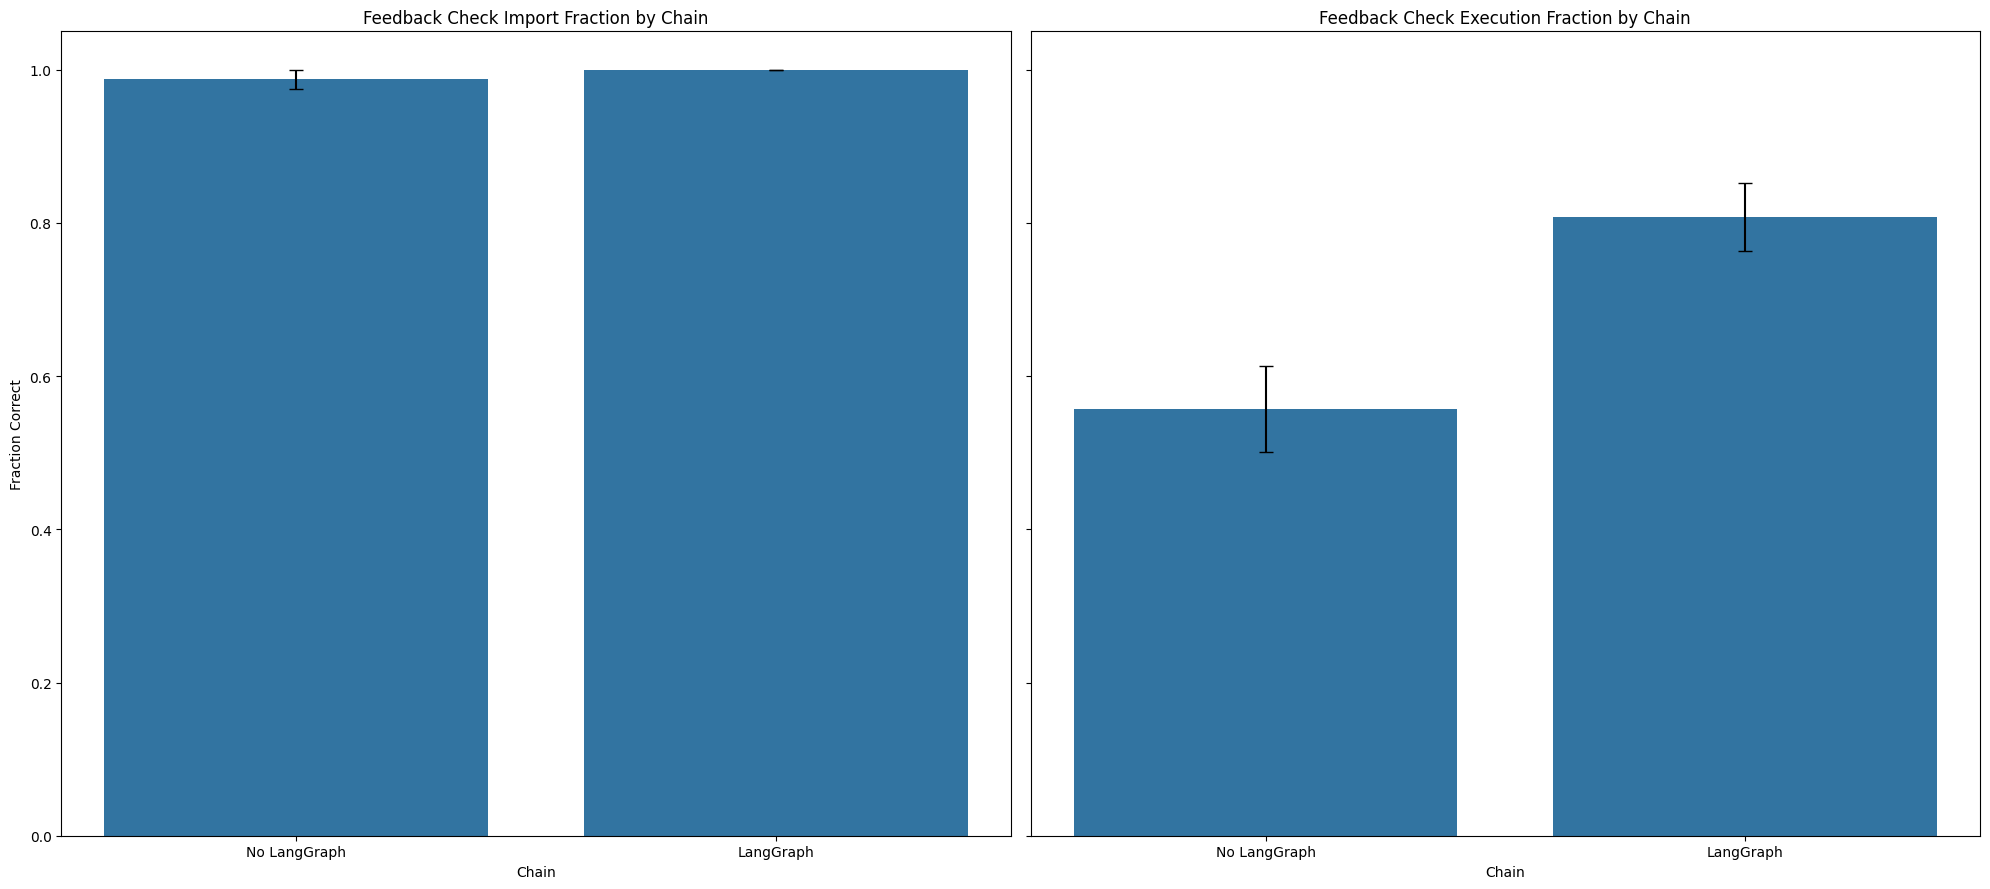

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


def plt_combined_bar_graph(df, fraction_fields, error_fields, titles, ylabels):
    """
    Plot bar graphs with error bars for specified fields in the provided DataFrame as subplots.

    Args:
    df (pd.DataFrame): The DataFrame containing the data to be plotted.
    fraction_fields (list[str]): List of column names in the DataFrame to be plotted on the y-axis for fractions.
    error_fields (list[str]): List of column names in the DataFrame to be plotted for standard errors.
    titles (list[str]): Titles of the plots.
    ylabels (list[str]): Labels for the y-axis.

    This function does not return any value but displays the bar graph.
    """
    n = len(fraction_fields)  # Number of plots to create
    fig, axs = plt.subplots(1, n, figsize=(10 * n, 9), sharey=True)

    for i, (fraction_field, error_field, title, ylabel) in enumerate(
        zip(fraction_fields, error_fields, titles, ylabels)
    ):
        barplot = sns.barplot(
            x="chain",
            y=fraction_field,
            data=df.sort_values(
                "chain", ascending=False
            ),  # Sort the DataFrame to reverse the order
            ax=axs[i],
            capsize=0.1,
            errorbar=None,
        )

        # Add error bars manually
        for j, bar in enumerate(barplot.patches):
            # Get the error for the current bar
            error = df.sort_values("chain", ascending=False)[error_field].iloc[j]
            # Add error bars to each bar
            axs[i].errorbar(
                x=bar.get_x() + bar.get_width() / 2,
                y=bar.get_height(),
                yerr=error,
                fmt="none",
                capsize=5,
                color="black",
            )

        axs[i].set_title(title)
        axs[i].set_xlabel("Chain")
        axs[i].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()


# Define the columns and labels for the plots
fraction_fields = ["Fraction Imports Correct", "Fraction Execution Correct"]
error_fields = ["Imports Correct Std Error", "Execution Correct Std Error"]

titles = [
    "Feedback Check Import Fraction by Chain",
    "Feedback Check Execution Fraction by Chain",
]
ylabels = ["Fraction Correct", "Fraction Correct"]

# Call the function with the specified arguments
plt_combined_bar_graph(
    correct_frac_and_errors, fraction_fields, error_fields, titles, ylabels
)